<a href="https://colab.research.google.com/github/advaitds2021/Cureya-Internship/blob/main/Week4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **WEEK4 TASK: TITANIC SURVIVAL PROJECT**

Import required libraries

In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

# Data Dictionary:
**Survival:** Survival of the passenger

**Passenger id:** Unique id of the passenger

**pclass:** ticket class

**sex:** Sex

**sibsp:**    # of siblings / spouses aboard the Titanic   

**parch:**    # of parents / children aboard the Titanic 

**ticket:**    Ticket number  

**fare:**    Passenger fare  

**cabin:**    Cabin number    

**embarked:**    Port of Embarkation


**1. Download and read dataset**

In [76]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train (3).csv


In [77]:
import io
df_train = pd.read_csv(io.BytesIO(uploaded['train.csv']))

In [78]:
uploaded = files.upload()

Saving test.csv to test (2).csv


In [82]:
df_test = pd.read_csv(io.BytesIO(uploaded['test.csv']))

In [81]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [83]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


 **2. Data pre-processing**

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


There are a total of 11 features and a target variable(Survived) in the dataset.
Features Age, Cabin and Embarked contains null values

In [ ]:
df_train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

Let us calculate percentage of missing values

In [ ]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()* 100)/(df_train.isnull().count())
df_percent_missing = pd.concat([total,percent],1)

In [ ]:
df_percent_missing

,0,1
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467
Fare,0,0.000000
Ticket,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Sex,0,0.000000
Name,0,0.000000
Pclass,0,0.000000


Looking at the percentage of missing values of Cabin, which is 77% of the entire data, we can drop this column for further analysis.
We can fill null values for Embarked and Age needs to be further investigated.

In [84]:
df_train = df_train.drop('Cabin',axis=1)

In [85]:
df_test = df_test.drop('Cabin', axis=1)

In [86]:
data = [df_train, df_test]

for dataset in data:
    mean = df_train["Age"].mean()
    std = df_test["Age"].std()
    is_null = dataset["Age"].isnull().sum()
    # compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    # fill NaN values in Age column with random values generated
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice
    dataset["Age"] = df_train["Age"].astype(int)
df_train["Age"].isnull().sum()

0

In [87]:
df_train['Age'].value_counts()

18    40
24    37
22    35
25    33
30    32
      ..
74     1
66     1
12     1
53     1
80     1
Name: Age, Length: 71, dtype: int64

In [88]:
df_train['Embarked'].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

Since there are only 2 missing values in Embarked feature, we replace the null values with most frequency data(S)

In [89]:
common_value = 'S'
data = [df_train, df_test]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna(common_value)


In [90]:
df_train['Embarked'].isnull().sum()

0

Convert the datatype of Fare from float to int

In [91]:
data = [df_train, df_test]

for dataset in data:
    dataset['Fare'] = dataset['Fare'].fillna(0)
    dataset['Fare'] = dataset['Fare'].astype(int)

Use name feature to extract titles and build new feature

In [92]:
data = [df_train, df_test]
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in data:
    # extract titles
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    # replace titles with a more common title or as Rare
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    # convert titles into numbers
    dataset['Title'] = dataset['Title'].map(titles)
    # filling NaN with 0, to get safe
    dataset['Title'] = dataset['Title'].fillna(0)
df_train = df_train.drop(['Name'], axis=1)
df_test = df_test.drop(['Name'], axis=1)

In [41]:
df_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
0,1,0,3,male,22,1,0,A/5 21171,7,S,1
1,2,1,1,female,38,1,0,PC 17599,71,C,3
2,3,1,3,female,26,0,0,STON/O2. 3101282,7,S,2
3,4,1,1,female,35,1,0,113803,53,S,3
4,5,0,3,male,35,0,0,373450,8,S,1


Convert 'Sex' feature to numeric

In [93]:
genders = {"male": 0, "female": 1}
data = [df_train, df_test]

for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(genders)

Ticket

In [43]:
len(df_train['Ticket'].unique())

681

Ticket contains 681 unique entries, we drop the column Ticket

In [94]:
df_train = df_train.drop(['Ticket'], axis=1)
df_test = df_test.drop(['Ticket'], axis=1)

Convert 'Embarked' feature to numeric

In [95]:
ports = {"S":0, "C":1, "Q":2}
data = [df_train, df_test]

In [96]:
for dataset in data:
  dataset['Embarked'] = dataset['Embarked'].map(ports)

**Creating categories:**

Age





In [54]:
data = [df_train, df_test]



In [55]:
for dataset in data:
    dataset['Age'] = dataset['Age'].astype(int)
    dataset.loc[ dataset['Age'] <= 11, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <= 18), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 22), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <= 27), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 27) & (dataset['Age'] <= 33), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 33) & (dataset['Age'] <= 40), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 66), 'Age'] = 6
    dataset.loc[ dataset['Age'] > 66, 'Age'] = 6

In [56]:
df_train['Age'].value_counts()

0    891
Name: Age, dtype: int64

Fare:

In [ ]:
data = [df_train, df_test]



In [ ]:
for dataset in data:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[(dataset['Fare'] > 31) & (dataset['Fare'] <= 99), 'Fare']   = 3
    dataset.loc[(dataset['Fare'] > 99) & (dataset['Fare'] <= 250), 'Fare']   = 4
    dataset.loc[ dataset['Fare'] > 250, 'Fare'] = 5
    dataset['Fare'] = dataset['Fare'].astype(int)

Creating new features:

1.Age time class

In [ ]:
data = [df_train, df_test]
for dataset in data:
    dataset['Age_Class']= dataset['Age']* dataset['Pclass']

2.Fare per person

In [97]:
data = [df_train, df_test]
for dataset in data:
    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['relatives'] > 0, 'not_alone'] = 0
    dataset.loc[dataset['relatives'] == 0, 'not_alone'] = 1
    dataset['not_alone'] = dataset['not_alone'].astype(int)
df_train['not_alone'].value_counts()

1    537
0    354
Name: not_alone, dtype: int64

In [ ]:
for dataset in data:
    dataset['Fare_Per_Person'] = dataset['Fare']/(dataset['relatives']+1)
    dataset['Fare_Per_Person'] = dataset['Fare_Per_Person'].astype(int)

In [98]:
df_train

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,relatives,not_alone
0,1,0,3,0,22,1,0,7,0,1,1,0
1,2,1,1,1,38,1,0,71,1,3,1,0
2,3,1,3,1,26,0,0,7,0,2,0,1
3,4,1,1,1,35,1,0,53,0,3,1,0
4,5,0,3,0,35,0,0,8,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,0,27,0,0,13,0,5,0,1
887,888,1,1,1,19,0,0,30,0,2,0,1
888,889,0,3,1,15,1,2,23,0,2,3,0
889,890,1,1,0,26,0,0,30,1,1,0,1


Passenger_id is unnecessary for further analysis and hence we drop that column

In [99]:
df_train = df_train.drop('PassengerId', axis=1)
df_test = df_test.drop('PassengerId', axis=1)

**3.Data Visualization**

Age and Sex

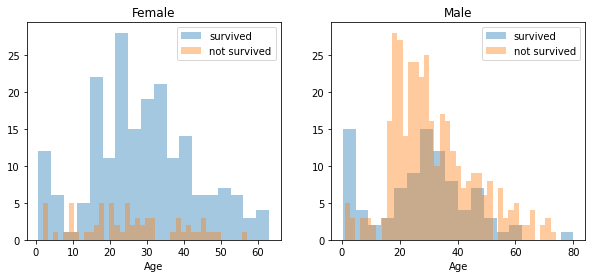

In [ ]:
survived = 'survived'
not_survived = 'not survived'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
women = df_train[df_train['Sex']=='female']
men = df_train[df_train['Sex']=='male']
ax = sns.distplot(women[women['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[0], kde =False)
ax = sns.distplot(women[women['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[0], kde =False)
ax.legend()
ax.set_title('Female')
ax = sns.distplot(men[men['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[1], kde = False)
ax = sns.distplot(men[men['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[1], kde = False)
ax.legend()
_ = ax.set_title('Male')
plt.show()

Survival rate of female was better in comparison for females in comparison to their male counterparts

P- Class

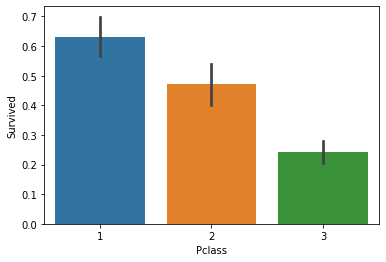

In [ ]:
sns.barplot(x='Pclass', y='Survived', data=df_train)
plt.show()

##### The survival rate is dependent on the ticket class.
#####From the bar plot, it can be stated that the passengers with class 1 survived the most while class 3 survived the least.

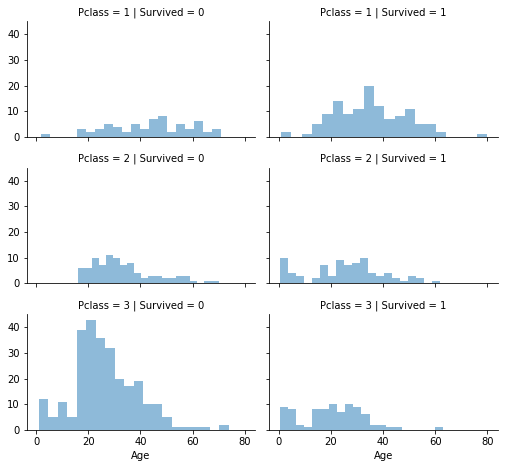

In [ ]:
grid = sns.FacetGrid(df_train, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

**5.Split your whole dataset into training and testing dataset**


In [100]:
X_train = df_train.drop("Survived", axis=1)
Y_train = df_train["Survived"]
X_test = df_test

**6. Predict the survival using the following algorithms:**

**a) Logistic Regression**

In [104]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)

Y_pred = logreg.predict(X_test)

acc_log = round(logreg.score(X_train, Y_train) * 100, 2)

In [105]:
print(acc_log)

81.48


In [106]:
predictions = cross_val_predict(logreg, X_train, Y_train, cv=3)
confusion_matrix(Y_train, predictions)

array([[468,  81],
       [ 95, 247]])

**Total number of passenger survived :** 328





**b)SVM**

In [107]:
linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)

Y_pred = linear_svc.predict(X_test)

acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)

In [108]:
print(acc_linear_svc)

80.81


In [109]:
predictions = cross_val_predict(linear_svc, X_train, Y_train, cv=3)
confusion_matrix(Y_train, predictions)

array([[356, 193],
       [ 57, 285]])

**Total number of passengers survived:** 387

**c) Ensemble learning techniques**

Bagging Method: Random Forest

In [111]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)

Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)

In [112]:
print(acc_random_forest)

96.97


In [113]:
predictions_rf = cross_val_predict(random_forest, X_train, Y_train, cv=3)
confusion_matrix(Y_train, predictions_rf)

array([[458,  91],
       [ 94, 248]])

**Total number of passengers survived:** 339

Boosting : XGBoost

In [114]:
xgb_model = XGBClassifier(max_depth = 10, gamma = 1)
xgb_model.fit(X_train, Y_train)
acc_xgb_model = round(xgb_model.score(X_train, Y_train) * 100, 2)


In [115]:
predictions_xgb = cross_val_predict(xgb_model, X_train, Y_train, cv=3)
confusion_matrix(Y_train, predictions_xgb)

array([[481,  68],
       [ 91, 251]])

**Total number of passengers survived:** 319

In [117]:
results = pd.DataFrame({'Model': ['Logistic Regression', 'Support Vector Machine' , 
              'Random Forest', 'XGBoost'],
    'Score': [acc_log, acc_linear_svc, 
              acc_random_forest, acc_xgb_model]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Score')
result_df.head(9)

,Model
Score,
96.97,Random Forest
91.47,XGBoost
81.48,Logistic Regression
80.81,Support Vector Machine


7. **Model Accuracy:**

In [124]:
y_pred_rf = random_forest.predict(X_train)

In [125]:
model_accuracy = accuracy_score(Y_train, y_pred_rf)

In [132]:
print("Accuracy of the model is:",round(model_accuracy*100,2), '%')

Accuracy of the model is: 96.97 %


**8.Evaluation metrics:**

In [135]:
mse = mean_squared_error(Y_train, y_pred_rf)
rmse = np.sqrt(mse)

In [136]:
print(rmse)

0.17407765595569785
